## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 

import pylab as pl
import matplotlib.pyplot as plt 
import time 

%matplotlib inline

import os
import gym
import sys
from gym.envs.toy_text import discrete
from collections import defaultdict, namedtuple
import itertools
import matplotlib.pyplot as plt
import io
import random

## Creating Windy Grid World Environment

In [2]:
class WindyGridworldEnv(object):
  def __init__(self, king=False):
      # the setting of gridWorld rows and columns
      self.height = 7
      self.width = 10
      self.startPos = (3,0) #(column,row)
      self.currentPos = self.startPos # init the current position
      self.goalPos = (3,7)
      self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
      # Defining the action list : Up/Down/Left/Right
      self.actions_list = ['Up', 'Down', 'Left', 'Right']
      self.king = king
      if (self.king):
        self.actions_list += ['Up_Left', 'Up_Right', 'Down_Left', 'Down_Right']
      



  def cell(self, pos):
      return pos[1] + self.width * pos[0]  

  def checkTerminalState(self, state):
      return state == self.cell(self.goalPos)

  def rewardFunction(self, state):
      # When it reaches goal state then reward is 0 otherwise the reward is -1
      if state == self.cell(self.goalPos):
          return 0
      else:
          return -1    

  # return the new state s'
  def step(self, state, action):
    y = state % self.width
    x = int((state - y) / self.width)
    WIND = self.wind_strength

    if action == 'Up':
        pos = (max(x - 1 - WIND[y], 0), y)
    elif action == 'Down':
        pos = (max(min(x + 1 - WIND[y], self.height - 1), 0), y)
    elif action == 'Left':
        pos = (max(x - WIND[y], 0), max(y - 1, 0))
    elif action == 'Right':
        pos = (max(x - WIND[y], 0), min(y + 1, self.width - 1))

    elif action == 'Up_Left':
        pos = (max(x - 1 - WIND[y], 0), max(y - 1, 0))
    elif action == 'Up_Right':
        pos = (max(x - 1 - WIND[y], 0), min(y + 1, self.width - 1))
    elif action == 'Down_Left':
        pos = (max(min(x + 1 - WIND[y], self.height - 1), 0), max(y - 1, 0))
    elif action == 'Down_Right':
        pos = (max(min(x + 1 - WIND[y], self.height - 1), 0), min(y + 1, self.width - 1))
    return self.cell(pos)
             

  def StochasticWind(self, state, action):
    # new state without stochastic wind
    pos = self.step(state, action)
    x = pos % self.width
    y = int((pos - x) / self.width)
    
    # new state after adding stochastic wind
    StochasticWindOnState = self.cell((min(max(y + np.random.choice([1,-1,0]), 0), self.height - 1), x))
    
    return StochasticWindOnState

In [3]:
def showTrajectoryPath(world, traj):
  # Initialize gridworld
  world_map = np.zeros((world.height, world.width))
  for i,state in enumerate(traj):
      x = int(state % world.width)
      y = int((state - x) / world.width)
      world_map[y, x] = i + 1
  print(world_map)
  print("\n")

In [4]:
# functions for choosing the greedy action

def greedyAct(_q_dict):
    greedy_act = ''
    max_q = -1e10
    for act in world.actions_list:
        if _q_dict[act] > max_q:
            greedy_act = act
            max_q = _q_dict[act]
    return greedy_act


def eps_Greedy(q_dict, epsilon): 
    m = len(world.actions_list)
    greedy_act = greedyAct(q_dict)
    p = []
    for act in world.actions_list:
        if act == greedy_act:
            p.append((epsilon * 1. / m) + 1 - epsilon)
        else:
            p.append(epsilon * 1. / m)
    choice = np.random.choice(world.actions_list,size = 1, p = p)
    return choice[0]

## SARSA Algorithm

In [5]:
def gridWorld_SARSA(world, ep_max, alpha=0.1, epsilon=0.1, gamma=1, isStochastic=False):
  # Initialize all values of Q(s,a) in the Q_table with 0
  q_table = {}
  for state in range(world.height * world.width):
    q_table[state] = {}
    for act in world.actions_list:
        q_table[state][act] = 0


  ep = 1 # Episode counter
  ep_max = ep_max # maximum number of episodes
  step_ep_list = []
  steps_cnt = []
  alreadyConverged = False

  while ep < ep_max:
      # print("Episode: ", ep)
      step = 0
      visitedStates = []
      actionsTaken = []
      converged = True

      # Initialize state
      state = world.cell(world.startPos)
      trajectory = [state]
      # Choose action from state
      act = eps_Greedy(q_table[state], epsilon)
      
      while not world.checkTerminalState(state):
          if(isStochastic):
            state_prime = world.StochasticWind(state, act)
          else:
            state_prime = world.step(state, act)
          reward = world.rewardFunction(state_prime)

          visitedStates.append(state_prime)
          actionsTaken.append(act)

          act_prime = eps_Greedy(q_table[state_prime], epsilon)
          oldQ = q_table[state][act]
          q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
          if(abs(oldQ - q_table[state][act]) > epsilon):
            # print(abs(oldQ - q_table[state][act]))
            converged = False
          
          state = state_prime
          act = act_prime
          # Increase Step Counter
          step += 1
          # Store the index of the episode of this time step
          step_ep_list.append(ep)
          # Update the trajectory
          trajectory.append(state)
      
      
      if ep == (ep_max - 1):
          showTrajectoryPath(world, trajectory)
      # Increase the episode counter
      ep += 1
      steps_cnt.append(step)

      
      if(converged and not alreadyConverged):
        print("Found the optimal policy using Sarsa. The path is ...")
        print(visitedStates)
        print('-----------------------------------------------------\n')
        print("The actions taken on that path are ...")
        print(actionsTaken)
        print('-----------------------------------------------------\n')
        print("Converge at episode: ", ep)
        print('-----------------------------------------------------\n')
        alreadyConverged = True

  
  

  start_time = time.time()
  plt.plot(step_ep_list)
  print("Time elapsed is (in Secs): ", time.time() - start_time)
  plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
  plt.xlabel("Number of Steps taken")
  plt.ylabel("Number of Episodes")
  plt.show()

  
  if(isStochastic==False):
    print("\nObservation: It took " + str(min(steps_cnt)) + " steps to reach GOAL state for SARSA with ∈=" + str(epsilon) + ", α=" + str(alpha))
  else:
    print("\nObservation: It took " + str(min(steps_cnt)) + " steps to reach GOAL state for SARSA (Stochastic) with ∈=" + str(epsilon) + ", α=" + str(alpha))

  print("Discounted factor (gamma) is set as " + str(gamma))


## Q-Learning Algorithm

In [8]:
def gridWorld_QLearning(world, ep_max, alpha=0.1, gamma=1, epsilon=0.1, isStochastic=False):
    
    # Initialize Q(s, a)
    q_dict = {}
    for state in range(world.height * world.width):
        q_dict[state] = {}
        for act in world.actions_list:
            if world.checkTerminalState(state):
                q_dict[state][act] = 0
            else:
                q_dict[state][act] = np.random.rand()


    
    ep_max = ep_max # maximum number of episodes
    ep_wrt_step = []
    trajectory = []
    steps_cnt = []
    alreadyConverged = False

    for ep in range(1, ep_max + 1):
        s = world.cell(world.startPos)
        trajectory = []
        step = 0
        visitedStates = []
        actionsTaken = []
        converged = True

        while not world.checkTerminalState(s):
            # Choose act according to behaviour policy
            act = eps_Greedy(q_dict[s], epsilon)
            # take act, observe s_prime & reward
            if(isStochastic):
              s_prime = world.StochasticWind(s, act)
            else:
              s_prime = world.step(s, act)
            reward = world.rewardFunction(s_prime)

            visitedStates.append(s_prime)
            actionsTaken.append(act)

            # choose act_prime according to target policy
            act_prime = greedyAct(q_dict[s_prime])
            # Update Q(s, a)
            oldQ = q_dict[s][act]
            q_dict[s][act] += alpha * (reward + gamma * q_dict[s_prime][act_prime] - q_dict[s][act])
            if(abs(oldQ - q_dict[s][act]) > epsilon):
              # print(abs(oldQ - q_table[state][act]))
              converged = False

            # store trajectory
            trajectory.append(s)

            # update current state
            s = s_prime
            # store the index of this episode for plot
            ep_wrt_step.append(ep)
            step += 1

        trajectory.append(world.cell(world.goalPos))
        
        steps_cnt.append(step)

        if ep == (ep_max - 1):
          showTrajectoryPath(world, trajectory)

        if(converged and not alreadyConverged):
          print("Found the optimal policy using Sarsa. The path is ...")
          print(visitedStates)
          print('-----------------------------------------------------\n')
          print("The actions taken on that path are ...")
          print(actionsTaken)
          print('-----------------------------------------------------\n')
          print("Converge at episode: ", ep)
          print('-----------------------------------------------------\n')
          alreadyConverged = True

   
    start_time = time.time()
    plt.plot(ep_wrt_step)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

    if (isStochastic==False):
      print("\nObservation: It took " + str(min(steps_cnt)) + " steps to reach GOAL state for Q-Learning with ∈=" + str(epsilon) + ", α=" + str(alpha))
    else:
      print("\nObservation: It took " + str(min(steps_cnt)) + " steps to reach GOAL state for Q-Learning (Stochastic) with ∈=" + str(epsilon) + ", α=" + str(alpha))

    print("Discounted factor (gamma) is set as " + str(gamma))

## Observations

### SARSA

Executing SARSA algorithm with different combinations of ∈ and α.
* ∈=0.1, α=0.5
* ∈=0.2, α=0.1
* ∈=0.05, α=0.2

#### Observations for SARSA -> (∈=0.1, α=0.5)

Plot for Option: ∈=0.1,α=0.5 

Found the optimal policy using Sarsa. The path is ...
[31, 32, 33, 24, 15, 6, 7, 8, 9, 19, 29, 39, 49, 48, 37]
-----------------------------------------------------

The actions taken on that path are ...
['Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down', 'Down', 'Down', 'Down', 'Left', 'Left']
-----------------------------------------------------

Converge at episode:  187
-----------------------------------------------------

[[ 0.  0.  0.  0.  0.  0.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  4.  0.  0.  0. 18.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.012414693832397461


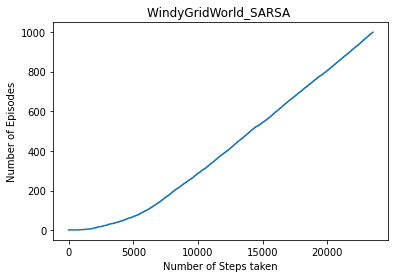


Observation: It took 15 steps to reach GOAL state for SARSA with ∈=0.1, α=0.5
Discounted factor (gamma) is set as 0.9


In [58]:
world = WindyGridworldEnv()
print("Plot for Option: ∈=0.1,α=0.5 \n")
gridWorld_SARSA(world, ep_max=1000, alpha=0.5, epsilon=0.1, gamma=0.9)

#### Observations for SARSA -> (∈=0.2, α=0.1)

Plot for Option: ∈=0.2,α=0.1 

Found the optimal policy using Sarsa. The path is ...
[20, 21, 31, 41, 31, 21, 22, 32, 22, 32, 31, 30, 31, 32, 33, 24, 15, 6, 7, 8, 9, 19, 29, 39, 49, 48, 48, 37]
-----------------------------------------------------

The actions taken on that path are ...
['Up', 'Right', 'Down', 'Down', 'Up', 'Up', 'Right', 'Down', 'Up', 'Down', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down', 'Down', 'Down', 'Down', 'Left', 'Down', 'Left']
-----------------------------------------------------

Converge at episode:  67
-----------------------------------------------------

[[ 0.  0.  0.  0.  0.  0. 10. 11. 12. 14.]
 [ 0.  0.  0.  0.  0.  9.  0.  0.  0. 15.]
 [ 0.  0.  0.  0.  7.  0.  0.  0.  0. 16.]
 [ 1.  4.  5.  6.  0.  0.  0. 20.  0. 17.]
 [ 2.  3.  0.  0.  0.  0.  0.  0. 19. 18.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.017748117446899

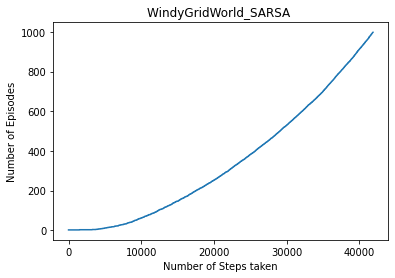


Observation: It took 15 steps to reach GOAL state for SARSA with ∈=0.2, α=0.1
Discounted factor (gamma) is set as 0.9


In [59]:
world = WindyGridworldEnv()
print("Plot for Option: ∈=0.2,α=0.1 \n")
gridWorld_SARSA(world, ep_max=1000, alpha=0.1, epsilon=0.2, gamma=0.9)

#### Observations for SARSA -> (∈=0.05, α=0.2)

Plot for Option: ∈=0.05,α=0.2 

Found the optimal policy using Sarsa. The path is ...
[31, 32, 42, 43, 34, 25, 16, 7, 8, 9, 19, 29, 39, 49, 48, 37]
-----------------------------------------------------

The actions taken on that path are ...
['Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down', 'Down', 'Down', 'Down', 'Left', 'Left']
-----------------------------------------------------

Converge at episode:  227
-----------------------------------------------------

[[ 0.  0.  0.  0.  0.  0.  0. 11. 12. 13.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0. 14.]
 [ 0.  0.  0.  0.  0.  9.  0.  0.  0. 15.]
 [ 1.  2.  3.  0.  6.  0.  0. 19.  0. 16.]
 [ 0.  0.  4.  5.  0.  0.  0.  0. 18. 17.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.014716625213623047


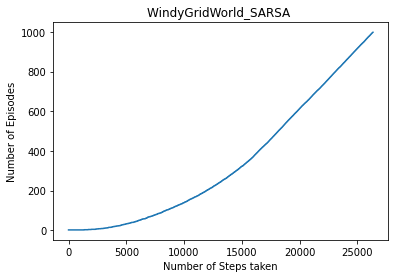


Observation: It took 15 steps to reach GOAL state for SARSA with ∈=0.05, α=0.2
Discounted factor (gamma) is set as 0.9


In [60]:
world = WindyGridworldEnv()
print("Plot for Option: ∈=0.05,α=0.2 \n")
gridWorld_SARSA(world, ep_max=1000, alpha=0.2, epsilon=0.05, gamma=0.9)

### Q-Learning

Executing Q-Learning algorithm with different combinations of ∈ and α.
* ∈=0.1, α=0.5
* ∈=0.2, α=0.1
* ∈=0.05, α=0.2

#### Observations for Q-Learning -> (∈=0.1, α=0.5)

Plot for Option: ∈=0.1,α=0.5 

Found the optimal policy using Sarsa. The path is ...
[31, 32, 33, 24, 15, 6, 6, 7, 8, 9, 9, 19, 29, 39, 49, 48, 37]
-----------------------------------------------------

The actions taken on that path are ...
['Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down', 'Right', 'Right', 'Right', 'Right', 'Down', 'Down', 'Down', 'Down', 'Left', 'Left']
-----------------------------------------------------

Converge at episode:  104
-----------------------------------------------------

[[ 0.  0.  0.  0.  0.  0.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 12.]
 [ 1.  2.  3.  4.  0.  0.  0. 16.  0. 13.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 15. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.10199880599975586


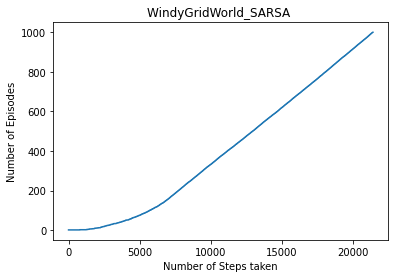


Observation: It took 15 steps to reach GOAL state for Q-Learning with ∈=0.1, α=0.5
Discounted factor (gamma) is set as 0.9


In [9]:
world = WindyGridworldEnv()
print("Plot for Option: ∈=0.1,α=0.5 \n")
gridWorld_QLearning(world, ep_max=1000, alpha=0.5, epsilon=0.1, gamma=0.9)

#### Observations for Q-Learning -> (∈=0.2, α=0.1)

Plot for Option: ∈=0.2,α=0.1 

Found the optimal policy using Sarsa. The path is ...
[40, 41, 51, 52, 53, 33, 33, 24, 15, 6, 7, 7, 8, 8, 9, 19, 29, 39, 49, 48, 37]
-----------------------------------------------------

The actions taken on that path are ...
['Down', 'Right', 'Down', 'Right', 'Right', 'Up', 'Down', 'Right', 'Right', 'Right', 'Right', 'Down', 'Right', 'Down', 'Right', 'Down', 'Down', 'Down', 'Down', 'Left', 'Left']
-----------------------------------------------------

Converge at episode:  60
-----------------------------------------------------

[[ 0.  0.  0.  0.  0.  7.  8.  9. 10. 11.]
 [ 0.  0.  0.  0.  6.  0.  0.  0.  0. 12.]
 [ 2.  3.  4.  5.  0.  0.  0.  0.  0. 13.]
 [ 1.  0.  0.  0.  0.  0.  0. 18.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 17. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.018100738525390625


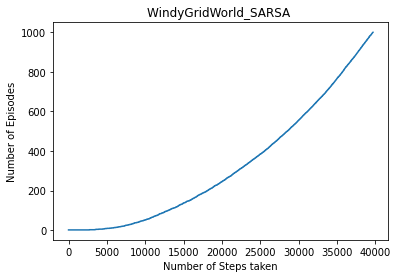


Observation: It took 15 steps to reach GOAL state for Q-Learning with ∈=0.2, α=0.1
Discounted factor (gamma) is set as 0.9


In [10]:
world = WindyGridworldEnv()
print("Plot for Option: ∈=0.2,α=0.1 \n")
gridWorld_QLearning(world, ep_max=1000, alpha=0.1, epsilon=0.2, gamma=0.9)

#### Observations for Q-Learning -> (∈=0.05, α=0.2)

Plot for Option: ∈=0.05,α=0.2 

Found the optimal policy using Sarsa. The path is ...
[31, 32, 33, 24, 15, 6, 7, 8, 9, 19, 29, 39, 49, 48, 37]
-----------------------------------------------------

The actions taken on that path are ...
['Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Down', 'Down', 'Down', 'Down', 'Left', 'Left']
-----------------------------------------------------

Converge at episode:  262
-----------------------------------------------------

[[ 0.  0.  0.  0.  0.  0.  7.  9. 10. 11.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0. 12.]
 [ 0.  0.  0.  0.  5.  0.  0.  0.  0. 13.]
 [ 1.  2.  3.  4.  0.  0.  0. 17.  0. 14.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 16. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.019808292388916016


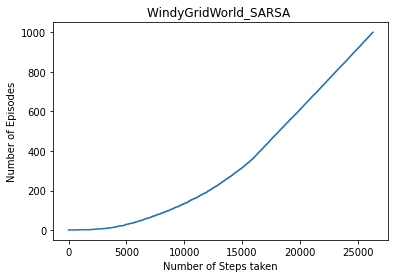


Observation: It took 15 steps to reach GOAL state for Q-Learning with ∈=0.05, α=0.2
Discounted factor (gamma) is set as 0.9


In [11]:
world = WindyGridworldEnv()
print("Plot for Option: ∈=0.05,α=0.2 \n")
gridWorld_QLearning(world, ep_max=1000, alpha=0.2, epsilon=0.05, gamma=0.9)

### SARSA (Stochastic wind) 

#### Observations for SARSA "Stochastic wind" -> (∈=0.1, α=0.5)

Plot for Option: ∈=0.1,α=0.5 

[[ 0.  0.  0.  0.  0. 11. 12.  0.  0. 15.]
 [ 0.  0.  0.  0.  0.  0. 10. 13. 14.  0.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0. 16.]
 [ 1.  2.  0.  0.  5.  0.  0. 28.  0. 19.]
 [ 0.  0.  0.  0.  0.  0.  0. 27.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0. 25.  0. 20.]
 [ 0.  0.  0.  4.  0.  0.  0.  0. 21.  0.]]


Time elapsed is (in Secs):  0.015141010284423828


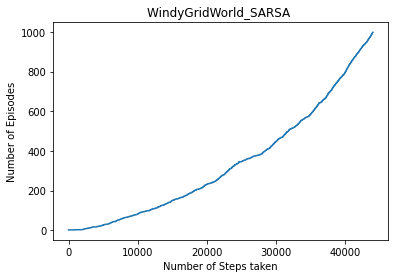


Observation: It took 7 steps to reach GOAL state for SARSA (Stochastic) with ∈=0.1, α=0.5
Discounted factor (gamma) is set as 0.9


In [69]:
world = WindyGridworldEnv(king=True)
print("Plot for Option: ∈=0.1,α=0.5 \n")
gridWorld_SARSA(world, ep_max=1000, alpha=0.5, epsilon=0.1, gamma=0.9, isStochastic=True)

#### Observations for SARSA "Stochastic wind"  -> (∈=0.2, α=0.1)

Plot for Option: ∈=0.2,α=0.1 

Found the optimal policy using Sarsa. The path is ...
[10, 0, 10, 0, 10, 20, 10, 11, 1, 22, 2, 2, 2, 22, 11, 11, 31, 11, 20, 20, 40, 40, 20, 41, 21, 20, 20, 20, 20, 21, 11, 22, 32, 32, 32, 42, 51, 40, 40, 60, 50, 30, 30, 30, 40, 50, 50, 50, 60, 60, 61, 41, 51, 51, 41, 50, 61, 51, 61, 50, 40, 41, 52, 32, 41, 40, 41, 32, 33, 3, 3, 13, 12, 2, 2, 1, 11, 10, 0, 0, 20, 20, 31, 41, 60, 60, 60, 60, 50, 41, 62, 62, 42, 42, 42, 52, 53, 43, 13, 13, 3, 4, 4, 4, 4, 4, 3, 3, 3, 2, 3, 2, 1, 1, 21, 21, 31, 20, 20, 10, 1, 12, 11, 2, 3, 4, 5, 5, 15, 5, 15, 15, 15, 14, 4, 13, 13, 23, 2, 21, 30, 31, 22, 31, 20, 20, 1, 2, 3, 2, 12, 12, 1, 10, 20, 10, 31, 22, 41, 31, 40, 20, 11, 30, 10, 20, 20, 10, 20, 40, 41, 41, 40, 50, 61, 52, 62, 62, 62, 61, 50, 30, 31, 42, 33, 23, 3, 4, 5, 4, 3, 13, 12, 21, 32, 31, 31, 11, 22, 13, 4, 5, 6, 16, 6, 6, 16, 5, 14, 4, 3, 2, 11, 11, 1, 0, 0, 0, 1, 20, 30, 40, 40, 41, 22, 13, 14, 13, 22, 23, 13, 4, 15, 6, 15, 4, 13, 2, 13, 12, 21, 22, 12, 13, 14

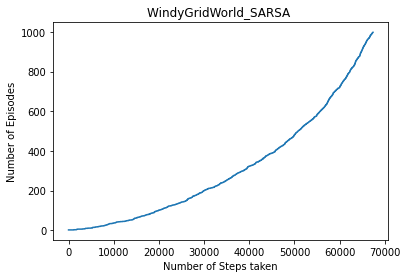


Observation: It took 7 steps to reach GOAL state for SARSA (Stochastic) with ∈=0.2, α=0.1
Discounted factor (gamma) is set as 0.9


In [70]:
world = WindyGridworldEnv(king=True)
print("Plot for Option: ∈=0.2,α=0.1 \n")
gridWorld_SARSA(world, ep_max=1000, alpha=0.1, epsilon=0.2, gamma=0.9, isStochastic=True)

#### Observations for SARSA "Stochastic wind" -> (∈=0.05, α=0.2)

Plot for Option: ∈=0.05,α=0.2 

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  9.  0.  0.]
 [ 0.  0.  0.  4.  5.  6.  8.  0.  0.  0.]]


Time elapsed is (in Secs):  0.17740130424499512


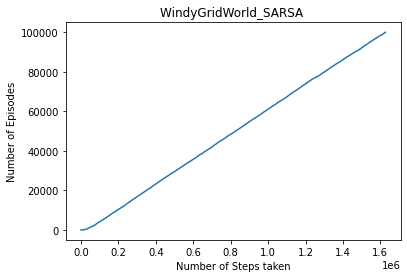


Observation: It took 7 steps to reach GOAL state for SARSA (Stochastic) with ∈=0.05, α=0.2
Discounted factor (gamma) is set as 0.9


In [74]:
world = WindyGridworldEnv(king=True)
print("Plot for Option: ∈=0.05,α=0.2 \n")
gridWorld_SARSA(world, ep_max=100000, alpha=0.2, epsilon=0.05, gamma=0.9, isStochastic=True)

### Q-Learning (Stochastic wind) 

#### Observations for Q-Learning "Stochastic wind" -> (∈=0.1, α=0.5)

Plot for Option: ∈=0.1, α=0.5 

[[ 0.  0.  0.  0.  0.  0.  0.  8.  9. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 13. 28.]
 [ 0.  0.  0.  0.  0.  0.  7.  0. 27. 23.]
 [ 1.  0.  0.  0.  0.  6.  0. 33. 30. 29.]
 [ 0.  0.  0.  0.  5.  0.  0. 26.  0. 31.]
 [ 0.  2.  0.  4.  0.  0.  0.  0. 32.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0. 20.  0.]]


Time elapsed is (in Secs):  0.017882585525512695


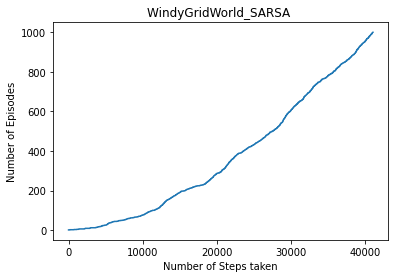


Observation: It took 7 steps to reach GOAL state for Q-Learning (Stochastic) with ∈=0.1, α=0.5
Discounted factor (gamma) is set as 0.9


In [12]:
world = WindyGridworldEnv(king=True)
print("Plot for Option: ∈=0.1, α=0.5 \n")
gridWorld_QLearning(world, ep_max=1000, alpha=0.5, epsilon=0.1, gamma=0.9, isStochastic=True)

#### Observations for Q-Learning "Stochastic wind" -> (∈=0.2, α=0.1)

Plot for Option: ∈=0.2, α=0.1 

Found the optimal policy using Sarsa. The path is ...
[40, 61, 62, 53, 42, 21, 22, 21, 11, 22, 13, 4, 13, 12, 3, 3, 3, 4, 13, 4, 13, 12, 3, 13, 24, 5, 6, 15, 6, 5, 4, 13, 4, 3, 4, 14, 3, 2, 13, 2, 3, 14, 15, 6, 15, 15, 6, 5, 15, 14, 3, 13, 14, 24, 5, 5, 4, 4, 3, 2, 3, 14, 25, 6, 17, 7, 17, 17, 8, 19, 18, 7, 8, 17, 16, 5, 4, 5, 5, 4, 13, 2, 3, 2, 13, 13, 4, 14, 23, 12, 23, 12, 1, 1, 21, 2, 11, 0, 1, 1, 2, 2, 12, 13, 2, 21, 30, 30, 51, 52, 33, 22, 11, 22, 13, 24, 5, 5, 15, 15, 14, 13, 13, 3, 4, 3, 3, 2, 13, 4, 5, 4, 4, 13, 12, 11, 1, 0, 10, 31, 40, 61, 62, 63, 62, 63, 53, 22, 41, 52, 53, 63, 63, 44, 15, 6, 6, 5, 4, 5, 5, 16, 7, 17, 7, 7, 7, 8, 7, 6, 7, 17, 16, 5, 14, 5, 4, 5, 5, 6, 6, 15, 24, 13, 23, 14, 14, 15, 16, 5, 4, 5, 14, 13, 4, 13, 4, 4, 13, 4, 13, 22, 33, 3, 3, 2, 2, 13, 14, 24, 5, 15, 14, 3, 4, 3, 14, 5, 14, 15, 14, 23, 12, 3, 13, 13, 4, 4, 5, 6, 6, 16, 5, 5, 5, 4, 15, 15, 6, 7, 8, 19, 39, 39, 38, 28, 8, 7, 7, 8, 9, 9, 9, 18, 19, 8, 7, 8, 9, 19, 

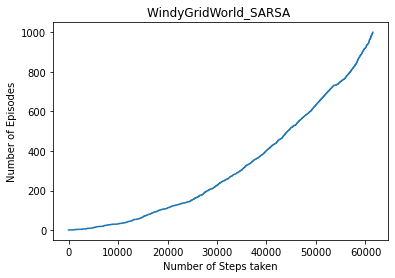


Observation: It took 7 steps to reach GOAL state for Q-Learning (Stochastic) with ∈=0.2, α=0.1
Discounted factor (gamma) is set as 0.9


In [13]:
world = WindyGridworldEnv(king=True)
print("Plot for Option: ∈=0.2, α=0.1 \n")
gridWorld_QLearning(world, ep_max=1000, alpha=0.1, epsilon=0.2, gamma=0.9, isStochastic=True)

#### Observations for Q-Learning "Stochastic wind" -> (∈=0.05, α=0.2)

Plot for Option: ∈=0.05, α=0.2 

[[ 0.  0.  0.  0.  0. 13. 14. 15.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0. 16. 17.]
 [ 0.  0.  0. 11. 12.  9.  0.  0. 19. 20.]
 [ 2.  0.  0.  0.  7.  8.  0. 24.  0. 18.]
 [ 0.  4.  5.  6.  0.  0.  0.  0. 22. 21.]
 [ 0.  0.  0.  0.  0.  0.  0. 23.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Time elapsed is (in Secs):  0.01994037628173828


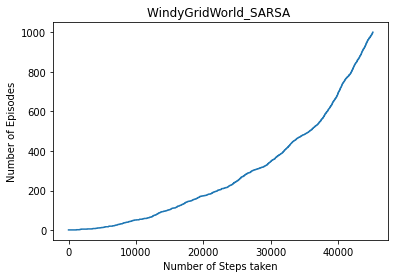


Observation: It took 7 steps to reach GOAL state for Q-Learning (Stochastic) with ∈=0.05, α=0.2
Discounted factor (gamma) is set as 0.9


In [14]:
world = WindyGridworldEnv(king=True)
print("Plot for Option: ∈=0.05, α=0.2 \n")
gridWorld_QLearning(world, ep_max=1000, alpha=0.2, epsilon=0.05, gamma=0.9, isStochastic=True)

## Report

> The report for this document can be found in the following URL : https://docs.google.com/document/d/1dbGOkdUnvJspCkeZAGilBJSvosASiXf-/edit?usp=sharing&ouid=112346818325505267561&rtpof=true&sd=true 